In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import stats
import libpysal as ps
from spreg import OLS, ML_Lag, ML_Error, GM_Lag 
from esda.moran import Moran
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from esda.moran import Moran, Moran_Local
from spreg import OLS, ML_Lag, ML_Error
import warnings
from data_preparation import listings_gdf, pm_gdf


All neighbourhoods match
Data Preparation Complete. Final Listings Count: (37158, 11), variables: ['price', 'geometry', 'room_type', 'property_type', 'accommodates', 'bedrooms', 'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'neighbourhood_cleansed', 'log_price']
Data Preparation Complete. Final Listings Count for Palermo: (5571, 11), variables: ['price', 'geometry', 'room_type', 'property_type', 'accommodates', 'bedrooms', 'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'neighbourhood_cleansed', 'log_price']


Data ready: 5844 listings in Palermo.


c:\Users\carru\Desktop\geospatial project\.venv\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)



--- RQ1: Global Spatial Autocorrelation ---
Global Moran's I: 0.153
P-value: 0.0010
Result: Significant CLUSTERING detected (prices are not random).


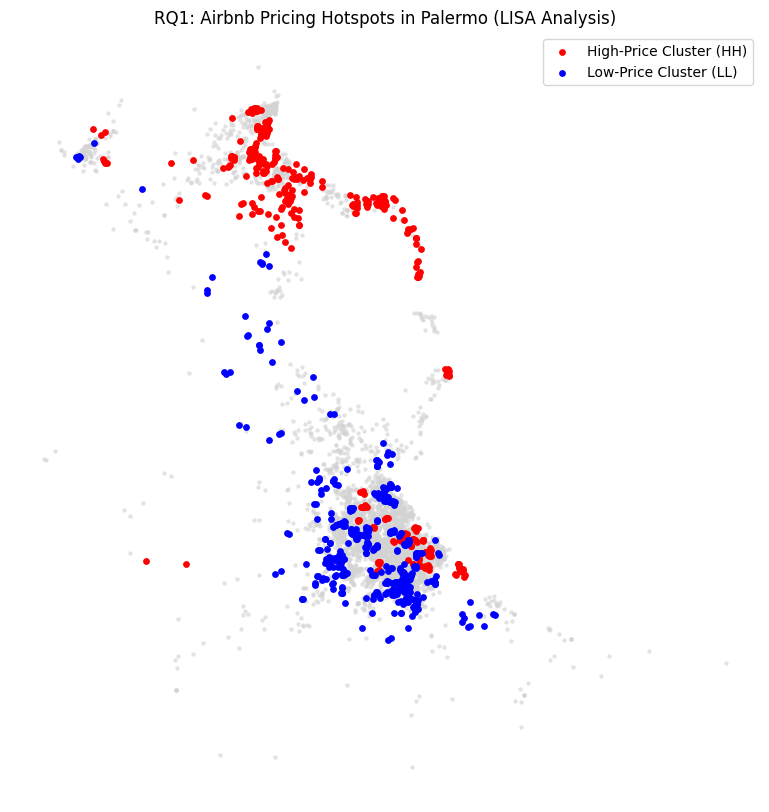


--- RQ3: Spatial Regression Analysis ---
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Palermo Listings
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        5844
Mean dependent var  :      4.4133                Number of Variables   :           4
S.D. dependent var  :      0.6123                Degrees of Freedom    :        5840
R-squared           :      0.1958
Adjusted R-squared  :      0.1954
Sum squared residual:     1761.63                F-statistic           :    473.9039
Sigma-square        :       0.302                Prob(F-statistic)     :  1.327e-275
S.E. of regression  :       0.549                Log likelihood        :   -4788.287
Sigma-square ML     :       0.301                Akaike info criterion :    9584.573
S.E of regression ML:      0.5490                Schwarz criterion     :    9611.266

--------------

In [ ]:
# --- RQ1: SPATIAL CLUSTERING (Global & Local Moran's I) ---

# 1. Create Spatial Weights Matrix (W)
# We define 'neighbors' as the 8 nearest listings (KNN)
w = ps.weights.KNN.from_dataframe(pm_gdf, k=8)
w.transform = 'r'  # Row-standardize weights (so rows sum to 1)

# 2. Global Moran's I
# Does the price data cluster overall?
moran = Moran(pm_gdf['log_price'], w)
print("\n--- RQ1: Global Spatial Autocorrelation ---")
print(f"Global Moran's I: {moran.I:.3f}")
print(f"P-value: {moran.p_sim:.4f}")
if moran.p_sim < 0.05:
    print("Result: Significant CLUSTERING detected (prices are not random).")
else:
    print("Result: Random distribution.")

# 3. Local Moran's I (Hotspots)
# Where exactly are the high-price clusters?
lisa = Moran_Local(pm_gdf['log_price'], w)

# Assign the cluster category to the dataframe for plotting
# (1=HH, 2=LH, 3=LL, 4=HL) - HH = High price next to High price
pm_gdf['lisa_category'] = lisa.q
pm_gdf['lisa_p'] = lisa.p_sim

# Plotting the Hotspots
fig, ax = plt.subplots(figsize=(10, 10))
# Plot non-significant points in grey
pm_gdf[pm_gdf['lisa_p'] > 0.05].plot(ax=ax, color='lightgrey', markersize=5, alpha=0.5)
# Plot Significant Hotspots (High-High) in Red
pm_gdf[(pm_gdf['lisa_p'] <= 0.05) & (pm_gdf['lisa_category'] == 1)].plot(
    ax=ax, color='red', markersize=15, label='High-Price Cluster (HH)'
)
# Plot Significant Coldspots (Low-Low) in Blue
pm_gdf[(pm_gdf['lisa_p'] <= 0.05) & (pm_gdf['lisa_category'] == 3)].plot(
    ax=ax, color='blue', markersize=15, label='Low-Price Cluster (LL)'
)
ax.set_title("RQ1: Airbnb Pricing Hotspots in Palermo (LISA Analysis)")
plt.legend()
plt.axis('off')
plt.show()

# --- RQ3: SPATIAL REGRESSION (OLS vs Spatial Lag) ---

print("\n--- RQ3: Spatial Regression Analysis ---")

# 1. Define Variables
# Y = Log Price
# X = Structural characteristics
y = pm_gdf['log_price'].values.reshape((-1, 1))
X_vars = ['accommodates', 'number_of_reviews', 'review_scores_rating']
X = pm_gdf[X_vars].values

# 2. Run Baseline OLS (Ordinary Least Squares)
# This assumes location doesn't matter (independent observations)
ols = OLS(y, X, w=w, name_y='log_price', name_x=X_vars, name_ds='Palermo Listings')
print(ols.summary)

# 3. Diagnostics: Lagrange Multiplier (LM) Tests
# Check if we need a spatial model. Look at 'LM (lag)' and 'LM (error)' in the OLS summary.
# If LM (lag) is significant, it means neighbors' prices affect my price.

# 4. Run Spatial Lag Model (SAR)
# Formula: Price = rho * (Neighbors' Prices) + Beta * X + Error
# This measures the "Spillover Effect"
sar = ML_Lag(y, X, w=w, name_y='log_price', name_x=X_vars, name_ds='Palermo Listings')
print("\n" + "="*30 + "\n SPATIAL LAG MODEL (SAR) SUMMARY \n" + "="*30)
print(sar.summary)

# --- INTERPRETATION HELPER ---
rho = sar.rho
print(f"\n--- CONCLUSION ---")
print(f"The Spatial Autoregressive parameter (rho) is: {rho:.4f}")
if sar.z_stat[0][1] < 0.05: # Checking p-value of Rho (usually the first param in ML_Lag output)
    print("This is statistically significant.")
    print(f"INTERPRETATION: A 10% increase in the price of neighboring listings")
    print(f"is associated with a {rho*10:.2f}% increase in a listing's price,")
    print("holding structural quality (size, rating) constant.")
else:
    print("Spatial dependence was not found to be significant.")

c:\Users\carru\Desktop\geospatial project\.venv\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


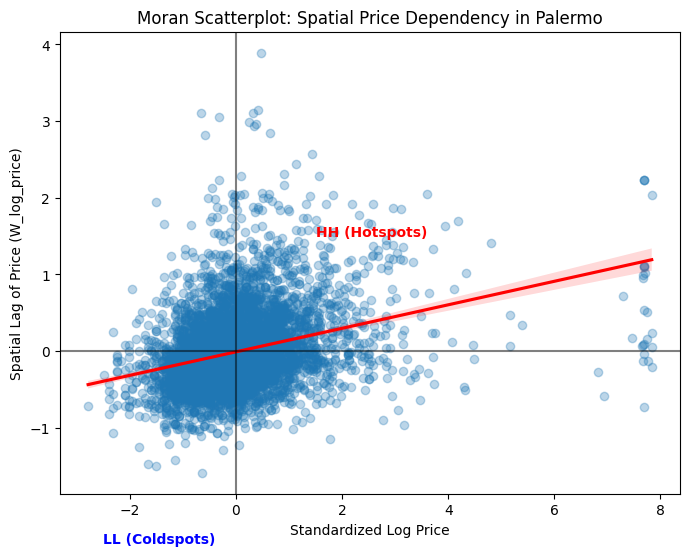

--- OLS DIAGNOSTICS ---
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        5844
Mean dependent var  :      4.4133                Number of Variables   :           4
S.D. dependent var  :      0.6123                Degrees of Freedom    :        5840
R-squared           :      0.1958
Adjusted R-squared  :      0.1954
Sum squared residual:     1761.63                F-statistic           :    473.9039
Sigma-square        :       0.302                Prob(F-statistic)     :  1.327e-275
S.E. of regression  :       0.549                Log likelihood        :   -4788.287
Sigma-square ML     :       0.301                Akaike info criterion :    9584.573
S.E of regression ML:      0.5490                Schwarz criterion     :    9611.266

------------------------------------

In [ ]:
# Suppress technical optimization warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


# --- 2. SPATIAL WEIGHTS ---
w = ps.weights.KNN.from_dataframe(pm_gdf, k=8)
w.transform = 'r'
y = pm_gdf['log_price'].values.reshape((-1, 1))
X = pm_gdf[X_vars].values

# --- 3. MODEL SELECTION & THE SDM "PATCH" ---

# A. OLS + Diagnostics
ols = OLS(y, X, w=w, spat_diag=True, name_y='log_price', name_x=X_vars)

# B. Manual Spatial Durbin Model (SDM)
X_lagged = ps.weights.spatial_lag.lag_spatial(w, X)
X_with_lags = np.hstack([X, X_lagged])
X_durbin_names = X_vars + [f"W_{v}" for v in X_vars]

sdm = ML_Lag(y, X_with_lags, w=w, name_y='log_price', name_x=X_durbin_names)

# --- THE FIX FOR THE TYPEERROR ---
# We force the diagnostic attributes back into standard Python floats
for attr in ['logll', 'aic', 'schwarz']:
    val = getattr(sdm, attr)
    if isinstance(val, np.ndarray):
        setattr(sdm, attr, float(val.item()))

# --- 4. VISUALIZATION: MORAN SCATTERPLOT (For your paper) ---
# This visualizes the spatial lag against the original price
std_y = (y - y.mean()) / y.std()
lag_std_y = ps.weights.spatial_lag.lag_spatial(w, std_y)

plt.figure(figsize=(8, 6))
sns.regplot(x=std_y.flatten(), y=lag_std_y.flatten(), 
            line_kws={"color": "red"}, scatter_kws={'alpha':0.3})
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.title("Moran Scatterplot: Spatial Price Dependency in Palermo")
plt.xlabel("Standardized Log Price")
plt.ylabel("Spatial Lag of Price (W_log_price)")
plt.text(1.5, 1.5, "HH (Hotspots)", color='red', weight='bold')
plt.text(-2.5, -2.5, "LL (Coldspots)", color='blue', weight='bold')
plt.show()

# --- 5. OUTPUTS ---
print("--- OLS DIAGNOSTICS ---")
print(ols.summary)

print("\n--- SPATIAL DURBIN MODEL (SDM) ---")
# The summary will now print without the TypeError
print(sdm.summary)

In [ ]:
warnings.filterwarnings("ignore")

# 1. Prepare coordinates and initial data
# (Assuming pm_gdf is your filtered Palermo GeoDataFrame from previous steps)
coords = np.column_stack((pm_gdf.geometry.x, pm_gdf.geometry.y))
y = pm_gdf['log_price'].values.reshape((-1, 1))

# 2. Calculate the "Critical Threshold" to ensure 0 islands
dist_threshold = ps.weights.min_threshold_distance(coords)

# 3. Create Distance Band Weights with Power Decay (alpha=-2)
# This accounts for distance decay: closer neighbors influence price more
w = ps.weights.DistanceBand.from_array(coords, threshold=dist_threshold, binary=False, alpha=-2.0)
w.transform = 'r'

print(f"Spatial Setup Complete.")
print(f"Distance Threshold: {dist_threshold:.2f} meters | Islands: {len(w.islands)}")


Spatial Setup Complete.
Distance Threshold: 1819.67 meters | Islands: 0


In [ ]:
model_ols = OLS(y, X, w=w, spat_diag=False, name_y='log_price', name_x=X_vars)

print("--- OLS RESULTS ---")
print(f"AIC: {model_ols.aic:.2f}")
print(f"Adjusted R-Squared: {model_ols.ar2:.3f}")
# Note: Check 'Prob' of Moran's I in the summary to prove spatial bias exists

--- OLS RESULTS ---
AIC: 9687.82
Adjusted R-Squared: 0.196


In [ ]:
# Run Maximum Likelihood Spatial Lag
model_sar = ML_Lag(y, X, w=w, name_y='log_price', name_x=X_vars)

# Patch for printing
for attr in ['logll', 'aic', 'schwarz']:
    val = getattr(model_sar, attr)
    if isinstance(val, np.ndarray): setattr(model_sar, attr, float(val.item()))

print("--- SAR (Spatial Lag) RESULTS ---")
print(f"AIC: {model_sar.aic:.2f}")
print(f"Spatial Autoregressive Coeff (Rho): {float(model_sar.rho):.4f}")

--- SAR (Spatial Lag) RESULTS ---
AIC: 9458.75
Spatial Autoregressive Coeff (Rho): 0.2696


In [ ]:
# 1. Manually create the Spatially Lagged X variables (The "Durbin" part)
X_lagged = ps.weights.spatial_lag.lag_spatial(w, X)
X_sdm = np.hstack([X, X_lagged])
names_sdm = X_vars + [f"W_{name}" for name in X_vars]

# 2. Run the Model
model_sdm = ML_Lag(y, X_sdm, w=w, name_y='log_price', name_x=names_sdm)

# Patch for printing
for attr in ['logll', 'aic', 'schwarz']:
    val = getattr(model_sdm, attr)
    if isinstance(val, np.ndarray): setattr(model_sdm, attr, float(val.item()))

print("--- SDM (Spatial Durbin) RESULTS ---")
print(f"AIC: {model_sdm.aic:.2f}")
print(f"Rho (Spatial Spillover): {float(model_sdm.rho):.4f}")
print("\nModel Summary:")
print(model_sdm.summary)

--- SDM (Spatial Durbin) RESULTS ---
AIC: 9464.44
Rho (Spatial Spillover): 0.2696

Model Summary:
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        5844
Mean dependent var  :      4.3993                Number of Variables   :           8
S.D. dependent var  :      0.6179                Degrees of Freedom    :        5836
Pseudo R-squared    :      0.2371
Spatial Pseudo R-squared:  0.2021
Log likelihood      :  -4724.2194
Sigma-square ML     :      0.2914                Akaike info criterion :    9464.439
S.E of regression   :      0.5398                Schwarz criterion     :    9517.824

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Err

In [33]:
from scipy.stats import chi2

# 1. Get Log-Likelihoods from your previous cells
ll_sdm = model_sdm.logll
ll_sar = model_sar.logll

# 2. Calculate LR Statistic
lr_stat = 2 * (ll_sdm - ll_sar)

# 3. Calculate p-value
# df is the number of 'W_' variables you added (in your case, 3)
p_val = chi2.sf(lr_stat, df=3)

print(f"LR Statistic: {lr_stat:.4f}")
print(f"p-value: {p_val:.4f}")

if p_val < 0.05:
    print("Reject H0: The SDM is significantly better than the SAR.")
else:
    print("Fail to reject H0: The SDM can be reduced to the SAR.")

LR Statistic: 0.3126
p-value: 0.9576
Fail to reject H0: The SDM can be reduced to the SAR.
